<h1 style="font-size: 22px; line-height: 100%; text-align: center; background-color: rgb(36, 24, 142); color: white; border: 4px solid rgb(36, 24, 142); border-radius: 10px;">
External Sub-network Search with BootstrapNAS
</h1>

This notebook demonstrates how to use an external search solution to find high-performing subnetworks in NNCF's [BootstrapNAS](https://github.com/openvinotoolkit/nncf/tree/develop/examples/experimental/torch/classification). We will use an existing super-network generated from ResNet-50.  

<h3 style="text-align: center; background-color: rgb(36, 24, 142); color: white; border: 4px solid rgb(36, 24, 142);
border-radius: 25px;">Imports and Settings
</h3>

In [ ]:
from imports_bnas import * # Import NNCF, PyTorch and other required packages.   

import os
from examples.common.sample_config import SampleConfig
from nncf.experimental.torch.nas.bootstrapNAS.search.supernet import TrainedSuperNet
from nncf.experimental.torch.nas.bootstrapNAS.elasticity.multi_elasticity_handler import SubnetConfig
from nncf.experimental.torch.nas.bootstrapNAS.elasticity.elasticity_dim import ElasticityDim

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

MODEL_DIR = Path("../../models/supernets/cifar10/resnet50")
OUTPUT_DIR = Path("output")
DATA_DIR = Path("data")
BASE_MODEL_NAME = "resnet-50"

fp32_pth_path, model_onnx_path, supernet_onnx_path, subnet_onnx_path = create_folders_demo(BASE_MODEL_NAME + '_external_search')


<h3 style="text-align: center; background-color: rgb(36, 24, 142); color: white; border: 4px solid rgb(36, 24, 142);
border-radius: 25px;">Loading an existing super-network
</h3>

In [ ]:
model = resnet50_cifar10()
config = SampleConfig.from_json(os.path.join(MODEL_DIR, 'config.json'))
config.device = device
print(MODEL_DIR)
supernet = TrainedSuperNet.from_checkpoint(model, config, os.path.join(MODEL_DIR, 'elasticity.pth'), os.path.join(MODEL_DIR, 'supernet_weights.pth'))

<h3 style="text-align: center; background-color: rgb(36, 24, 142); color: white; border: 4px solid rgb(36, 24, 142);
border-radius: 25px;">Explore the Search Space
</h3>



In [ ]:
supernet.get_search_space()

<h3 style="text-align: center; background-color: rgb(36, 24, 142); color: white; border: 4px solid rgb(36, 24, 142);
border-radius: 25px;">Data Loaders for validation and batchnorm adaptation
</h3>

In [ ]:
DATASET_DIR = DATA_DIR / "cifar10"

batch_size_val = 1000
batch_size = 64
train_loader, val_loader = create_cifar10_dataloader(DATASET_DIR, batch_size, batch_size_val, device)

<h3 style="text-align: center; background-color: rgb(36, 24, 142); color: white; border: 4px solid rgb(36, 24, 142);
border-radius: 25px;">Sample sub-networks to implement your own algorithm
</h3>


In [ ]:
# Implement your function to validate 
def acc_top1(model):
    from bootstrapnas_utils import validate
    model.eval()
    model.to(device)
    model_top1_acc, _, _ = validate(model, val_loader) 
    return model_top1_acc

supernet.activate_maximal_subnet()
supernet.eval_active_subnet(acc_top1)

In [ ]:
subnet_config = SubnetConfig()
subnet_config[ElasticityDim.DEPTH] = [1]

supernet.eval_subnet(subnet_config, acc_top1)

In [ ]:
supernet.activate_config(supernet.get_search_space())
supernet.get_macs_for_active_config()

In [ ]:
supernet.activate_config(supernet.get_search_space())
supernet.get_macs_for_active_config()

In [ ]:
subnet_config[ElasticityDim.DEPTH] = [0]
subnet_config[ElasticityDim.WIDTH] = {2: 512}

supernet.activate_config(subnet_config)
supernet.get_macs_for_active_config()

In [ ]:
supernet.get_active_config()

In [ ]:
supernet.eval_subnet(subnet_config, acc_top1)

<h3 style="text-align: center; background-color: rgb(36, 24, 142); color: white; border: 4px solid rgb(36, 24, 142);
border-radius: 25px;">Search using SigOpt
</h3>
In this section, you will need to have an account with SigOpt and create a project called BootstrapNAS. When prompted, you must enter your SigOpt token. 

In this demo, we will use just a few design variables to explore the search space using SigOpt. To better explore the search space, you can extend the parameters below to cover a large portion of the search space. 


In [ ]:
# %env SIGOPT_PROJECT BootstrapNAS
import sigopt
import numpy
%load_ext sigopt
%sigopt config

In [ ]:
def run_and_track_in_sigopt():

    # For this example, we are using a subset of the design variables. 
    accuracy = supernet.eval_subnet_with_design_vars([sigopt.params.x0, sigopt.params.x1, sigopt.params.x2, sigopt.params.x3, sigopt.params.x4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, sigopt.params.x37], acc_top1)

    macs = supernet.get_macs_for_active_config()
    
#     latency = supernet.eval_subnet(... )
    
    sigopt.log_metric(name='accuracy', value=accuracy)
    sigopt.log_metric(name='macs', value=macs)

In [ ]:
%%experiment
{
    'name': 'Subnet Search',
    'metrics': [
        {
            'name': 'accuracy',
            'strategy': 'optimize',
            'objective': 'maximize',
        },
        {
            'name': 'macs',
            'strategy': 'optimize',
            'objective': 'minimize',
        }
    ],
    'parameters': [
        {
            'name': 'x0',
            'type': 'int',
            'bounds': {'min': 0, 'max': 3}
        },
        {
            'name': 'x1',
            'type': 'int',
            'bounds': {'min': 0, 'max': 3}
        },
        {
            'name': 'x2',
            'type': 'int',
            'bounds': {'min': 0, 'max': 3}
        },
        {
            'name': 'x3',
            'type': 'int',
            'bounds': {'min': 0, 'max': 3}
        },
        {
            'name': 'x4',
            'type': 'int',
            'bounds': {'min': 0, 'max': 2}
        },
        {
            'name': 'x37',
            'type': 'int',
            'bounds': {'min': 0, 'max': 35}
        },
    ],
    'budget': 20
}

In [ ]:
%%optimize BootstrapNAS_Example
run_and_track_in_sigopt()

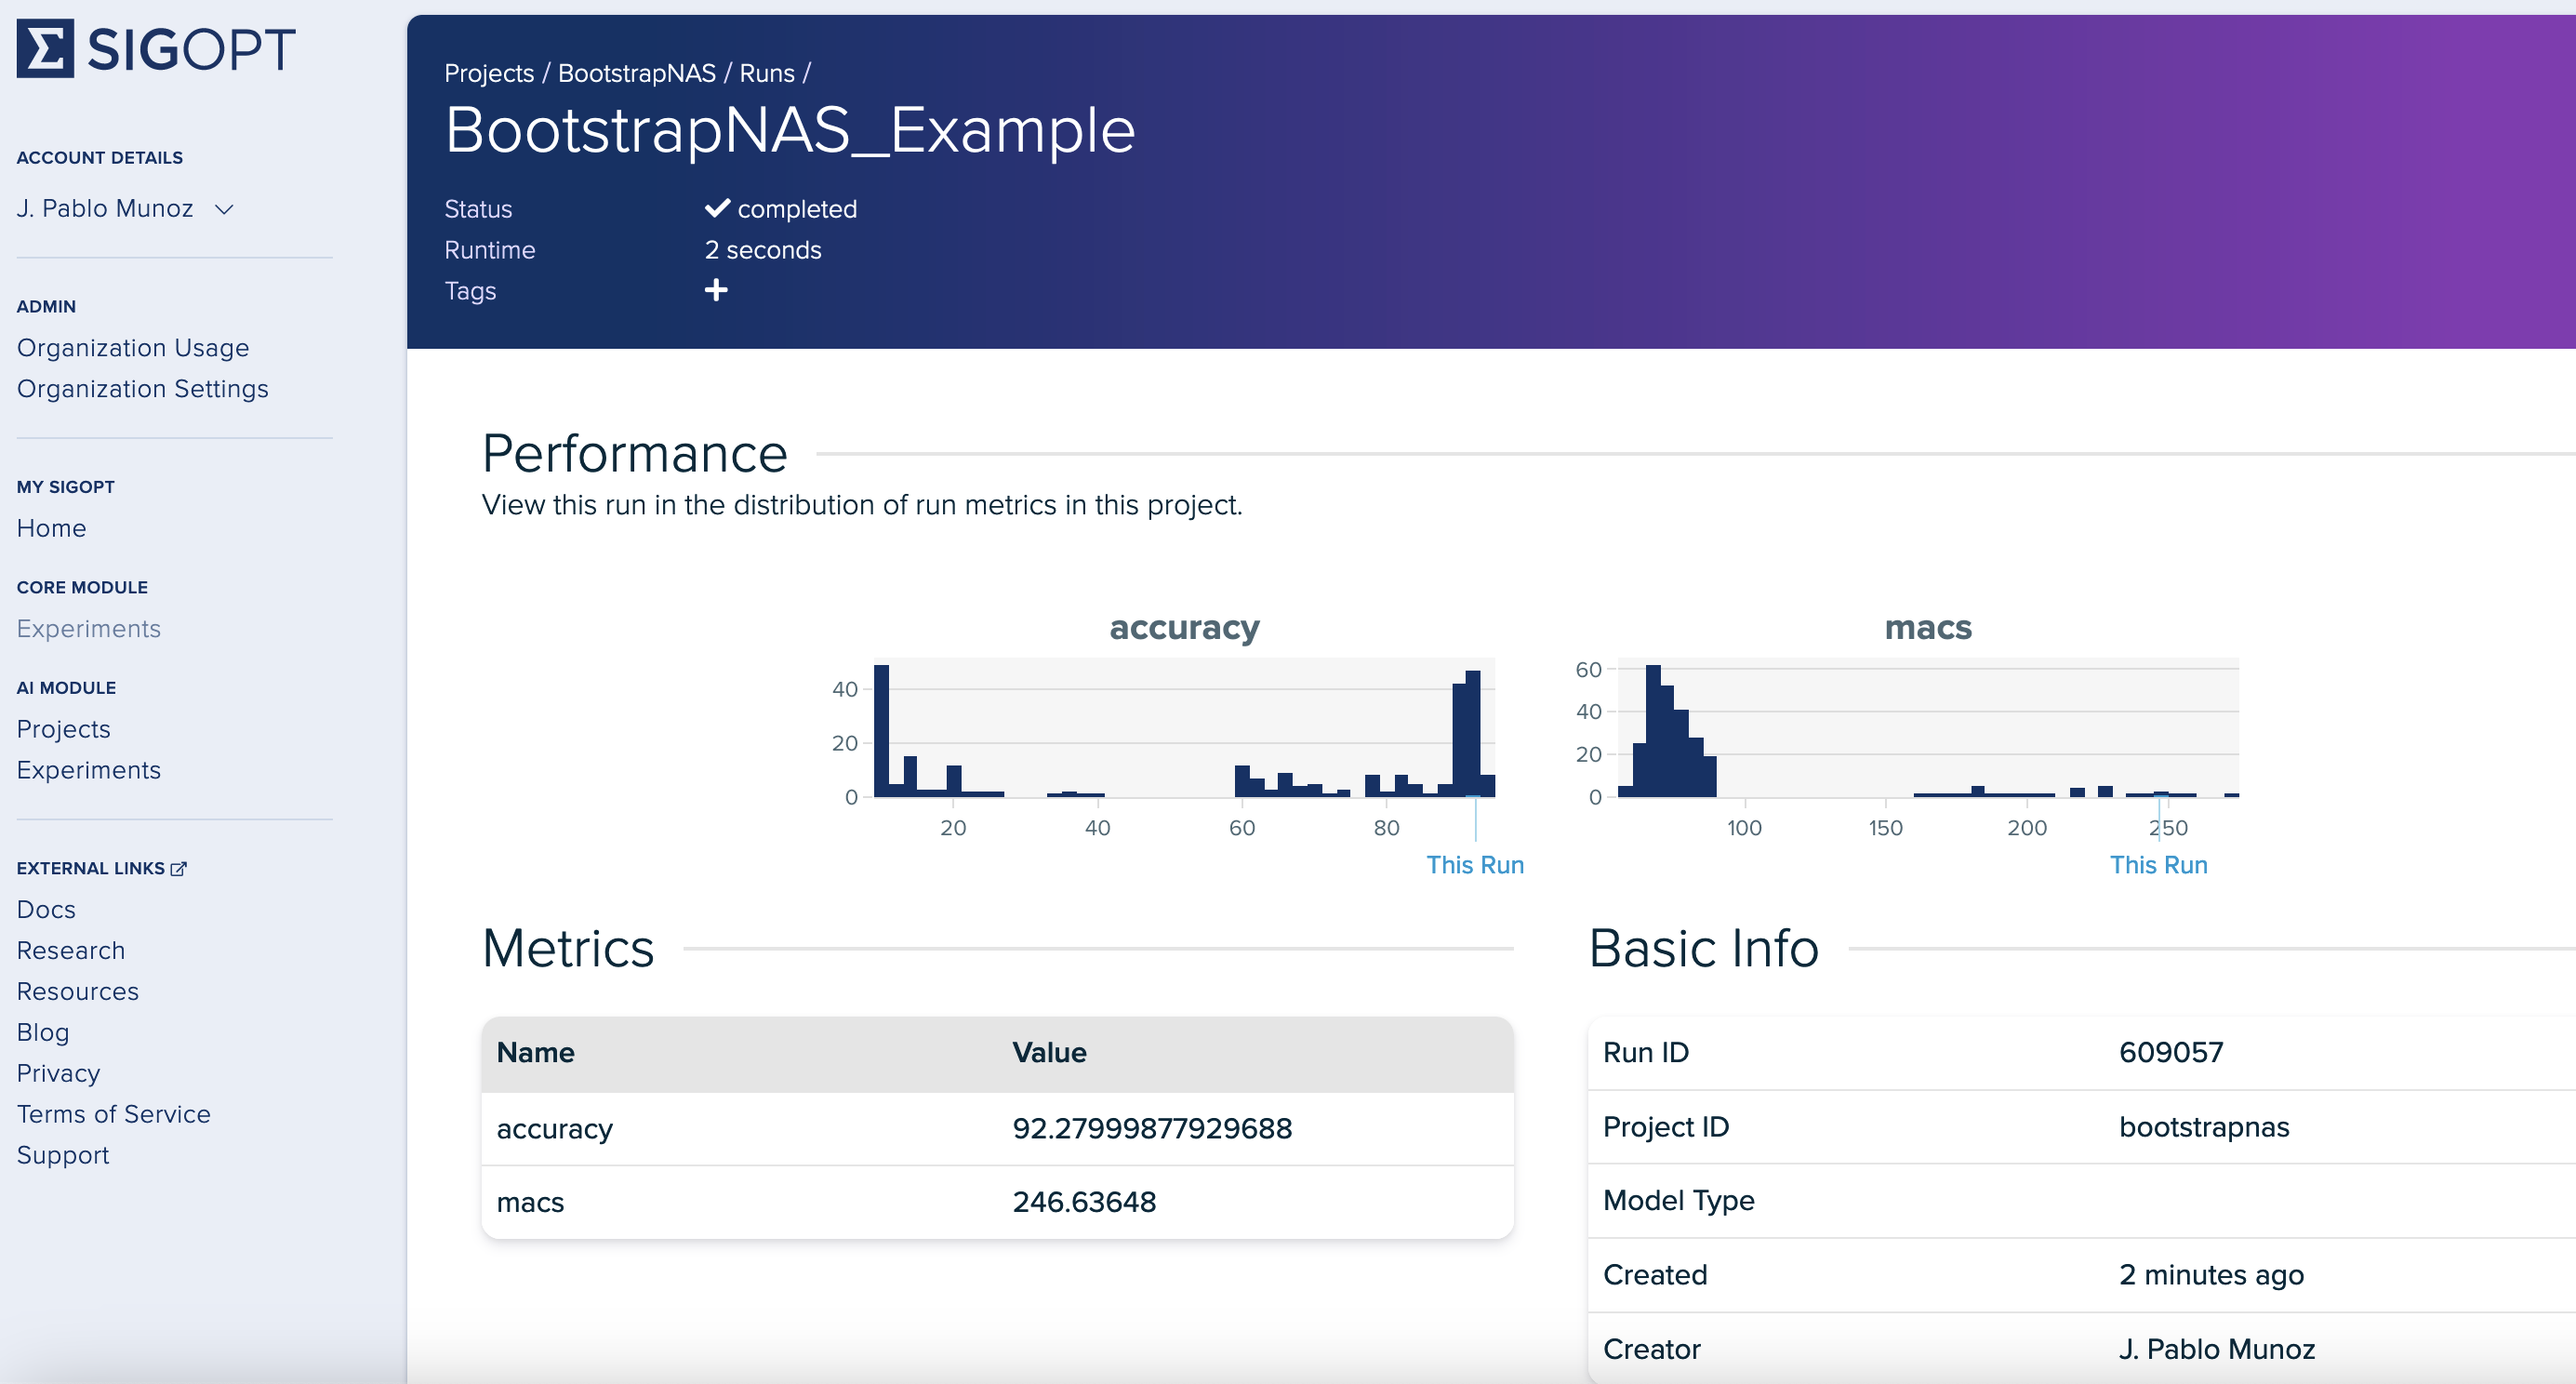